# Ising 3D  Simulation

## Introduction

In this notebook, we delve into the simulation of the Ising model in three dimensions (3D). The Ising model is a classic model in statistical mechanics that describes the behavior of magnetic spins in a lattice. We consider an $N \times N \times N$ cubic grid where each particle interacts with six neighboring particles, since we consider periodic boundary conditions. We will explore two different algorithms for simulating this model:

1. **Metropolis Hasting**
2. **Wolff Algorithm**

Our objective is to analyze the behavior of the model and establish the relationships between magnetization, temperature, and the size of the cubic grid. 

However, before starting, I would like to present the results found for lower dimensional Ising Models.

**Ising 1D**:

In this simple one-dimensional case, particles are arranged in a linear chain, interacting only with their immediate neighbors. The energy of the system is computed using the formula:

$\hspace{70mm} E = -J\sum_{i=1}^{N}s_{i} \cdot s_{i+1} $

<div style="text-align: center;">
    <img src="ISING1D.png">
</div>

Here, $s_i$ represents the spin of particle $i$. Notably, the average magnetization $M$ in this model is always zero, indicating that particles cannot polarize.



**Ising 2D**:

Moving to a two-dimensional square grid, employing periodic boundary conditions, each particle interacts with four others. The energy of this system is given by:

$\hspace{70mm} E = -J\sum_{n.n(i,j)}^{N}s_{i} \cdot s_{j} $


<div style="text-align: center;">
    <img src="pazz.png">
</div>


Unlike the 1D case, in 2D, we observe non-zero positive or negative magnetization below a critical temperature $T_c ∼ 2.269$. Beyond this critical temperature, $M = 0$.
 
<div style="text-align: center;">
    <img src="MagnetizationIsing2d_Final.png">
</div>

**Ising 3D**:

The 3D Ising model extends the previous 2D case to a cubic lattice. Employing continuous boundary conditions, each particle interacts with six others. The energy of the system is expressed as:

$\hspace{70mm}  E = -J\sum_{(i,j)n.n}^{N}s_{i} \cdot s_{j} $

<div style="text-align: center;">
    <img src="3disingmodel.png">
</div>

This model is the only one that has not been shown analytically. In this case we have only computational approximation telling us that $T_c  ∼ 4.5$ and after that we cannot expect the model to be magnetized.



## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

## Energy initialization

In [2]:
def energy_3d(state,grid):
    e = 0.0
    # Iterate over all dimensions
    for i in range(grid):
        for j in range(grid):
            for k in range(grid):
                # I add in a way boundary condition are also considered
                e -= state[i,j,k]*state[(i+1)%grid,j,k] 
                e -= state[i,j,k]*state[i,(j+1)%grid,k]
                e -= state[i,j,k]*state[i,j,(k+1)%grid]
    return e

## Metropolis Hasting
This is one of the first MonteCarlo algorithm used in order to simulate such experiments. This algorithm, as well as the other we will explore, reaches detailed balance. In loose speech, it is a good sampling algorithm for the Boltzmann Distribution which govern the Ising Model. Here I present the algoorithm:

**Algorithm:**
1. Choose a random spin $s_{0}$ and flip it
2. Compute change of energy by the flip of that spin $\Delta E = E_{new} - E_{old}$
    - if $\Delta E$ < 0 accept the move
    - otherwise accept it with probability $e^{\frac{-\Delta E}{T}}$
3. Repeat 1-2 for $n_{steps}$

### Parameter Initialization MH

In [3]:
grid = 5
nstep = 10000
seed = 123

### Utils MH

In [4]:
# Spin flip
def flip_MH(state,i,j,k):
    state[i,j,k] = - state[i,j,k]

# Metropolis acceptance
def MH_accept(e_old,e_new,T):
    if e_old > e_new:
        return True
    else:
        if np.random.random()< np.exp((e_old- e_new)/T):
            return True
        return False
    
# Magnetization computation
def magnetization(state):
    m = 0
    for space in state:
        for subspace in space:
            for s in subspace:
                m = m + s
    return m / grid / grid /grid
    
# Simulate and save the history of energy, magnetization and how the state changed
def simulate_MH(state,temp):
    e_old = energy_3d(state,grid)
    e_hist = []
    m_hist = []
    for i in range(nstep):
        # Let us pick random spin
        i,j,k = np.random.randint(grid,size = 3)
        #Flip it singularly
        flip_MH(state,i,j,k)
        # Compute new energy
        e_new = energy_3d(state,grid)
        # Metropolis step
        if MH_accept(e_old,e_new,temp):
            e_old = e_new
        else:
            flip_MH(state,i,j,k) # flip it again if move not accepted

        #Appending
        e_hist.append(e_old)
        m_hist.append(magnetization(state))

    return e_hist, m_hist, state

# This function will be used to plot magnetization against temperature
# wlog we take the average magnetization

def MagvsTemp_MH(state,temp,grid):
    
    m_hist = []
    # Compute old energy
    e_old = energy_3d(state,grid)
    for i in range(nstep):
        # Let us pick random spin
        i,j,k = np.random.randint(grid,size = 3)
        # Flip it
        flip_MH(state,i,j,k)
        # Compute new energy
        e_new = energy_3d(state,grid)
        # Metropolis step
        if MH_accept(e_old,e_new,temp):
            e_old = e_new
        else:
            flip_MH(state,i,j,k) # flip it again so do not accept the move
        # Appending
        m_hist.append(magnetization(state))
    return np.mean(m_hist) # I take the average magnetization around the steps

### Simulation MH

Here I initialize the spin randomly and plot it in a cubic grid

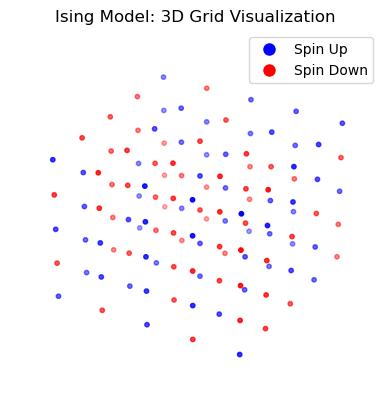

In [5]:
# Random seed
rnd.seed(123)

# Initialization
state = 2 * np.random.randint(2, size=(grid, grid, grid)) - 1

# Plot
fig_3d = plt.figure(figsize=(4, 6))
# Create a meshgrid for x, y and z coordinates
x, y, z = np.meshgrid(np.arange(grid), np.arange(grid), np.arange(grid))
# Flatten the state matrix for plotting
state_flat = state.flatten()
# Define colors (blue for 1, red for -1)
colors = np.where(state_flat == 1, 'blue', 'red')
# Create a 3D scatter plot
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors, marker='o', s=10)
ax_3d.set_title('Ising Model: 3D Grid Visualization')
ax_3d.set_axis_off()

# Adjust layout to prevent overlap
plt.tight_layout()
# Show legend
blue_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Spin Up')
red_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Spin Down')
plt.legend(handles=[blue_handle, red_handle])

# Show the subplots
plt.show()

Now I will provide some visualization to study and appreciate how energy and magnetization change according to temperature. Here for simplicty I fixed the grid size equal to 5.

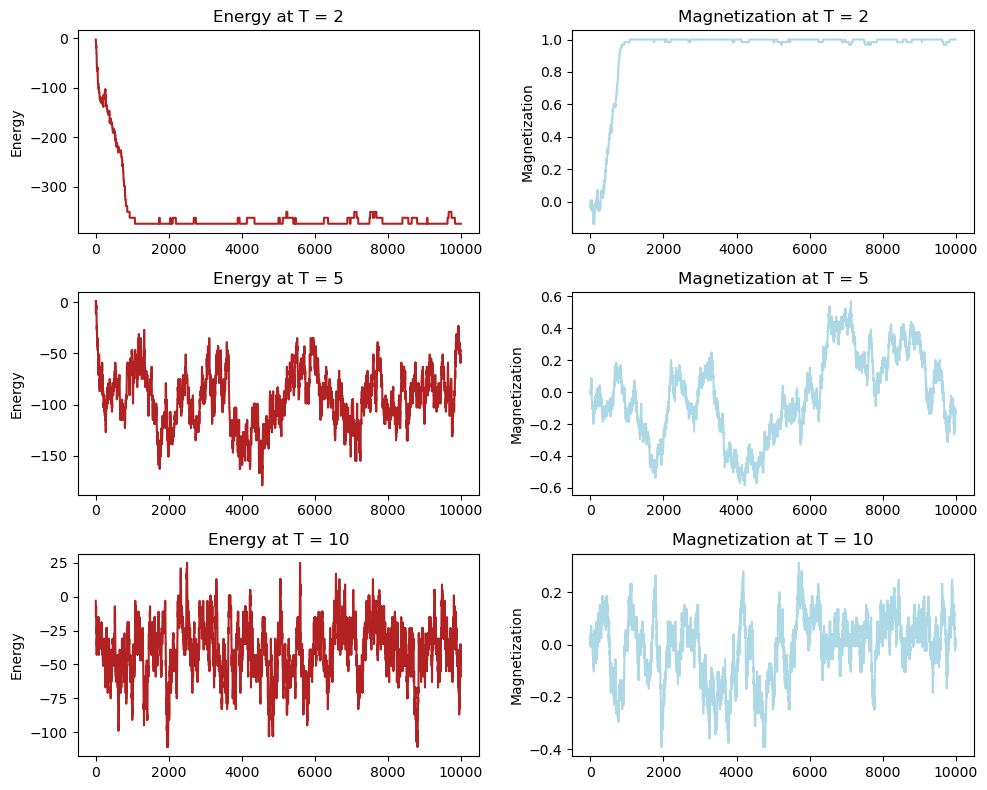

In [7]:
# Different temperatures
temp_list = [2,5,10]


# Create a new figure for energy and magnetization plots
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 8))

# First temperature
e_hist_1,m_hist_1,state_1 = simulate_MH(state.copy(),temp_list[0]) # I put state.copy() being sure we start from the same point
# Plot e_hist_1
ax1.plot(e_hist_1, color='firebrick')
ax1.set_title(f'Energy at T = {temp_list[0]}')
ax1.set_ylabel('Energy')
# Plot m_hist_1
ax2.plot(m_hist_1, color='lightblue')
ax2.set_title(f'Magnetization at T = {temp_list[0]}')
ax2.set_ylabel('Magnetization')

# Second Temperature
e_hist_2,m_hist_2,state_2= simulate_MH(state.copy(),temp_list[1])
# Plot e_hist_2
ax3.plot(e_hist_2, color='firebrick')
ax3.set_title(f'Energy at T = {temp_list[1]}')
ax3.set_ylabel('Energy')
# Plot m_hist_2
ax4.plot(m_hist_2, color='lightblue')
ax4.set_title(f'Magnetization at T = {temp_list[1]}')
ax4.set_ylabel('Magnetization')

# Third temperature
e_hist_3,m_hist_3,state_3= simulate_MH(state.copy(),temp_list[2])
# Plot e_hist_3
ax5.plot(e_hist_3, color='firebrick')
ax5.set_title(f'Energy at T = {temp_list[2]}')
ax5.set_ylabel('Energy')
# Plot m_hist_3
ax6.plot(m_hist_3, color='lightblue')
ax6.set_title(f'Magnetization at T = {temp_list[2]}')
ax6.set_ylabel('Magnetization')

plt.tight_layout()

plt.show()


Here we can observe very peculiar features. I plotted on purpose three temperatures:
1. **T = 1** :the Ising grid exhibits total polarization. Particles align predominantly in a single spin direction, rapidly achieving minimum energy and magnetization close to 1 or -1.
2. **T = 5**: This value lies proximate to the critical temperature $T_c  ∼ 4.5$. At this juncture, behavior tends towards randomness. However, the Metropolis-Hastings algorithm encounters challenges in converging to the minimum energy state, a phenomenon evident in the energy plot.
3. **T = 10**: at this considerably high temperature, the system is expected to be entirely depolarized, resulting in a magnetization near zero. Energy distribution should be relatively uniform across the grid, telling us the system ia able to explore different energy states. The latter is due to the fact that $P_{B}(x) = \frac{e^-\frac{E(x)}{T}}{Z} \rightarrow \frac{1}{Z} \ as  \ T \rightarrow \infty$. In fact, the system does not converge smoothly to the minima but instead exhibits oscillatory behavior.

We can also see it visually by the resulting 3D Ising Grids:

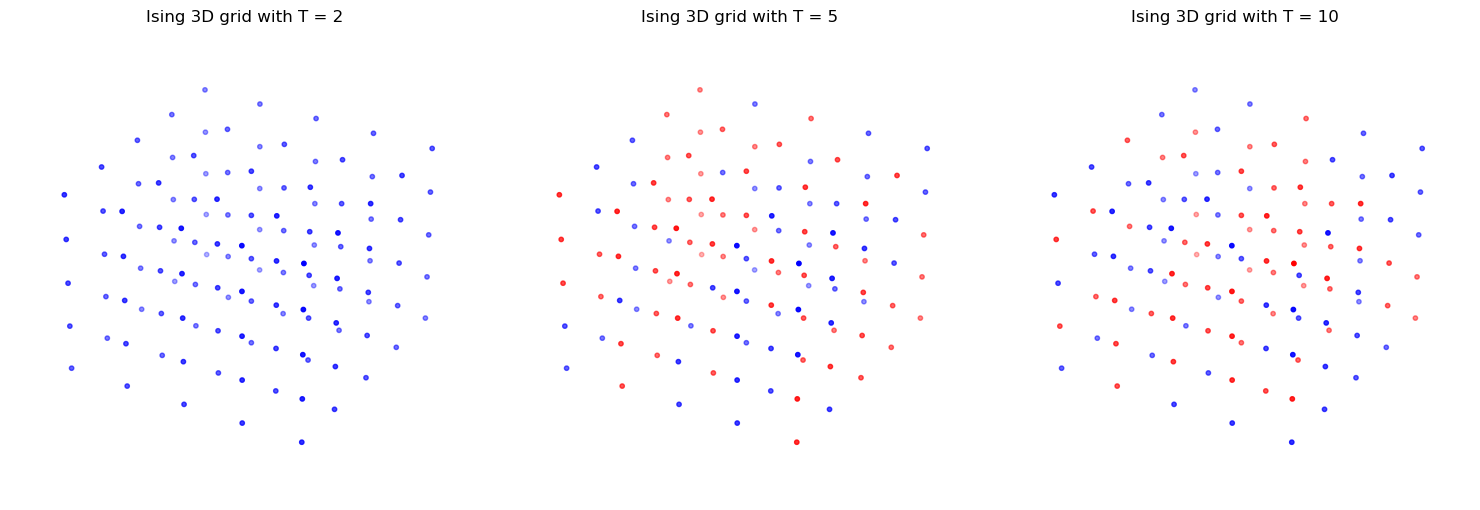

In [8]:
# Let us plot the 3 grids in order to have a visual representation

# Create a meshgrid for x, y, and z coordinates
x, y, z = np.meshgrid(np.arange(grid), np.arange(grid), np.arange(grid))

# Flatten the state matrix for plotting
state_flat_1 = state_1.flatten()
state_flat_2 = state_2.flatten()
state_flat_3 = state_3.flatten()  

# Define colors (blue for 1, red for -1)
colors1 = np.where(state_flat_1 == 1, 'blue', 'red')
colors2 = np.where(state_flat_2 == 1, 'blue', 'red')
colors3 = np.where(state_flat_3 == 1, 'blue', 'red')  

# Create a 3D scatter plot for the first state
fig_3d_1 = plt.figure(figsize=(15, 5))  
ax_3d_1 = fig_3d_1.add_subplot(131, projection='3d')  
ax_3d_1.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors1, marker='o', s=10)
ax_3d_1.set_title(f'Ising 3D grid with T = {temp_list[0]}')
ax_3d_1.set_axis_off()

# Create a 3D scatter plot for the second state
ax_3d_2 = fig_3d_1.add_subplot(132, projection='3d') 
ax_3d_2.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors2, marker='o', s=10)
ax_3d_2.set_title(f'Ising 3D grid with T = {temp_list[1]}')
ax_3d_2.set_axis_off()

# Create a 3D scatter plot for the third state
ax_3d_3 = fig_3d_1.add_subplot(133, projection='3d')  
ax_3d_3.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors3, marker='o', s=10)  
ax_3d_3.set_title(f'Ising 3D grid with T = {temp_list[2]}')
ax_3d_3.set_axis_off()

plt.tight_layout()
plt.show()


As anticipated, spin follows a unique direction at low temperatures. While, they have a more variegated behaviour at higher temperatures.

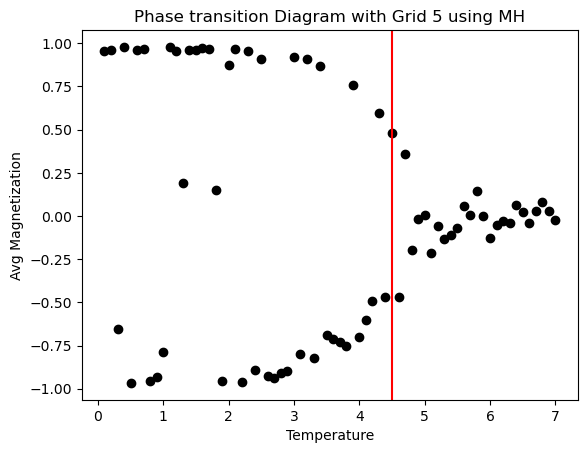

In [9]:
m = []
temp_for_plot = [0.1 +(0.1*step) for step in range(70)]
state = 2 * np.random.randint(2, size=(5, 5, 5)) - 1
for temps in temp_for_plot:
    m.append(MagvsTemp_MH(state.copy(), temps, 5))

plt.scatter(temp_for_plot,m,color = "black")
plt.title(f'Phase transition Diagram with Grid {5} using MH')
plt.ylabel("Avg Magnetization")
plt.xlabel("Temperature")
plt.axvline(x = 4.5, color = "red")
plt.show()

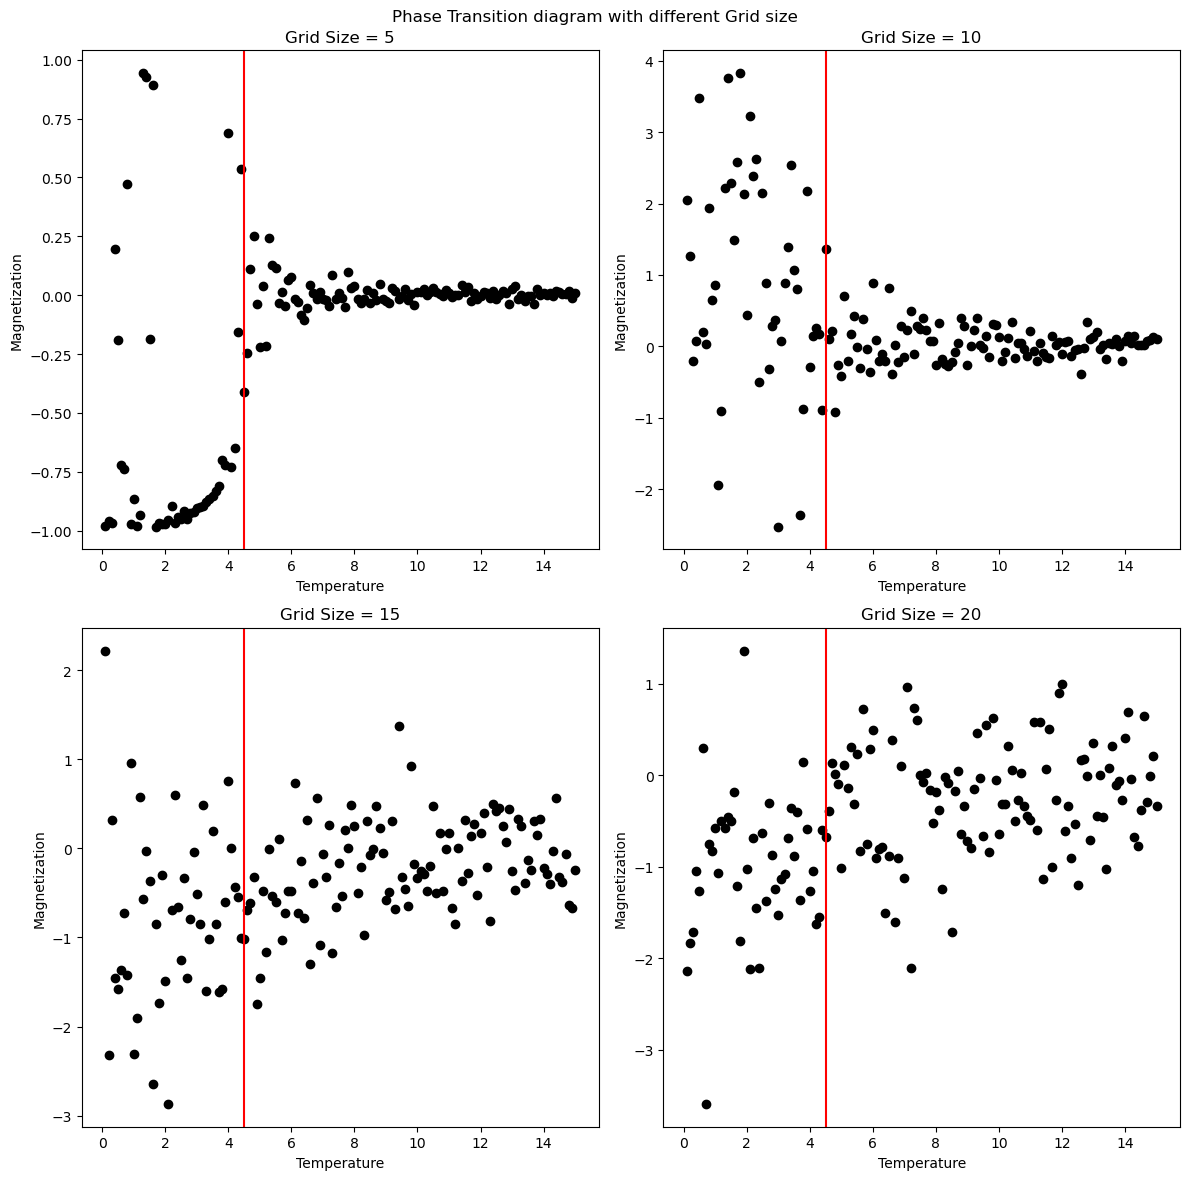

In [10]:
# Let us plot the magnetization against temperature
grid_array = [5,10,15,20]

# Plot all diagrams
temp_for_plot = [0.1 +(0.1*step) for step in range(150)]

# Create a new figure with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Phase Transition diagram with different Grid size')

# Plot diagrams for different grid sizes
for i, grid_val in enumerate(grid_array):
    m = []
    # State intialization
    state = 2 * np.random.randint(2, size=(grid_val, grid_val, grid_val)) - 1
    for temps in temp_for_plot:
        m.append(MagvsTemp_MH(state.copy(), temps, grid_val))
    axs[i // 2, i % 2].scatter(temp_for_plot, m,color = "black")
    axs[i // 2, i % 2].set_xlabel('Temperature')
    axs[i // 2, i % 2].set_ylabel('Magnetization')
    axs[i // 2, i % 2].axvline(x = 4.5,color = "red")
    axs[i // 2, i % 2].set_title(f'Grid Size = {grid_val}')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the subplots
plt.show()


The black points depict average magnetization, while the red line illustrates the numerical approximation of the 3D Ising model mentioned in the Introduction.

The plots indicate diminishing detail as grid size increases, suggesting a greater number of steps are needed for significant results.

Despite computational constraints, the theoretical approximation appears accurate, particularly evident in smaller grids where the critical temperature is clearly identifiable. At higher temperatures, magnetization uniformly tends toward zero, while at lower temperatures it approaches zero.

Although there is reduced clarity in higher grid sizes, there is a noticeable increase in the density of zero magnetization points beyond a certain temperature, suggesting the desired outcome has been achieved despite computational limitations.

## Wolff Algorithm
This algorithm was invented to reduce convergence times. In fact, instead of flip just one spin at a time, it chooses a cluster of neighbouring spin with the same sign and add them to the cluster with probability $P_{add}$. When the cluster is complete it flips the whole group of spins.

**Algorithm:**
1. Choose a random spin $s_{0}$ and initialize cluster C = [$s_{0}$]
2. Check if neigbours are in the same state and add to the cluster C with probability $P_{add} = 1 - e^{-2/T}$
3. Flip the entire cluster
2. Accept the move with probability 0.5
4. Repeat 1-4 for n_{steps}

The acceptance in Wolff algorithm is different since we want to reach detailed balance, meaning we want to sample by the Boltzmann distribution. In order to explain this choice suppose x,x' are two states which differ from one cluster flipping. To satisfy detailed balance in Wolff algorithm we want:

$\hspace{70mm}$ $ \frac{Q(1-Padd)^m A(x \rightarrow x')}{Q\cdot(1-Padd)^n A(x' \rightarrow x)} = e^{-\frac{E(x')-E(x)}{T}}$

Where:

1. Q = probability of forming that cluster
2. m = broken bonds (linkage between spin of the same sign) going from x to x'
2. n = broken bonds (linkage between spin of the same sign) going from x' to x
3. $A(z \rightarrow y)$ = acceptance probability from z to y

In this case $E(x) = \tilde{E} - m + n$ and $E(x') = \tilde{E} + m - n$. So the difference is $2(m-n)$. If for simplicty we assume that the acceptance probability is the same ( i.e $A(x \rightarrow x') = A(x' \rightarrow x) \forall x,x'$ ), as we will do in this algorithm supposing $A(x \rightarrow x') = 0.5 \  \forall x,x'$ we get:

$\hspace{70mm}$ $ (1-Padd)^{m-n} = e^{-2\frac{(m-n)}{T}}$

Finally, if we solve the equation we get the expression of $P_{add}$:

$\hspace{70mm}$ $ P_{add} = 1 - e^{-\frac{2}{T}}$


### Parameter Initialization WA

In [18]:
grid = 5
temp = 1
nstep = 500 # I use less steps since it converges faster
seed = 123
Padd = 1 - np.exp(-2/temp)

### Utils WA

In [19]:
# Find neighbours for Wolff algorithm
def find_neighbours(state,index_change,state_current,counter,Padd):

    length_old = len(index_change)
    # All possible types of neighbours
    neighbour_offsets = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (-1, 0, 0), (0, -1, 0), (0, 0, -1)]
    # Save how many neighbours are added
    changes = 0
    for i in range(counter,length_old):
        for x, y, z in neighbour_offsets:
            # Define the neighbours
            ni, nj, nk = index_change[i][0] + x, index_change[i][1] + y, index_change[i][2] + z
            # Let us check they don' go out the grid
            if 0 <= ni < state.shape[0] and 0 <= nj < state.shape[1] and 0 <= nk < state.shape[2]:
                a = state[ni, nj, nk]
                # If a is of the same state of the chosen spin and was not already chosen
                # we let it have the possibility of being flipped
                if a == state_current and (ni, nj, nk) not in index_change:
                    if np.random.rand() < Padd:
                        index_change.append((ni, nj, nk))
                        changes += 1
    # Counter saves up computational time by searching neighbours from spins from which we have not
    # checked the neighbours
    counter = length_old 
    return changes,counter


def flip_WA(state,temp,i,j,k):
    # I remember the old_state so If change not accepted I know how to come back
    old_state = state.copy()
    new_state = state.copy()
    # Save the current state
    state_current = state[i,j,k]
    # Here I keep a list of spin to change
    index_change = [(i,j,k)]
    # Stopping conditions
    counter,stop  = 0,0
    while stop == 0:
        changes ,counter= find_neighbours(old_state,index_change,state_current,counter,Padd = 1 - np.exp(-2/temp))
        # If nothing was added exit
        if changes == 0:
            stop = -1
    # Flip every chosen state
    for tuples in index_change:
        new_state[tuples[0],tuples[1],tuples[2]] = - new_state[tuples[0],tuples[1],tuples[2]]
    return old_state,new_state


# Wolff acceptance
def WA_accept():
    if np.random.random() < 0.5:
        return True
    return False
# Magnetization computation
def magnetization(state):
    m = 0
    for space in state:
        for subspace in space:
            for s in subspace:
                m = m + s
    return m / grid / grid /grid

# Let us simulate the metropolis algorithm
def simulate_WA(state,temp,grid):
    e_old = energy_3d(state,grid)
    e_hist = []
    m_hist = []
    for i in range(nstep):
        # Let us pick random spin
        i,j,k = np.random.randint(grid,size = 3)
        # Flip according to the cluster rule
        old , new = flip_WA(state,temp,i,j,k)
        e_new = energy_3d(new,grid)

        if WA_accept():
            e_old = e_new
            state = new
        else:
            state = old
        e_hist.append(e_old)
        m_hist.append(magnetization(state))
        
    return e_hist, m_hist, state

# For plotting the magnetization you take the last one which should be close to the one
# at which the system converge
def MagvsTemp_WA(state,temp,grid):
    m = []
    for i in range(nstep):
        # Let us pick random spin
        i,j,k = np.random.randint(grid,size = 3)
        # Flip according to the cluster rule
        old , new = flip_WA(state,temp,i,j,k)
        # Wolff acceptance probability
        if WA_accept():
            state = new
        else:
            state = old   
        m.append(magnetization(state))
        
    return np.mean(m)

### Simulated WA

Here I initialize the spin randomly and plot it in a cubic grid

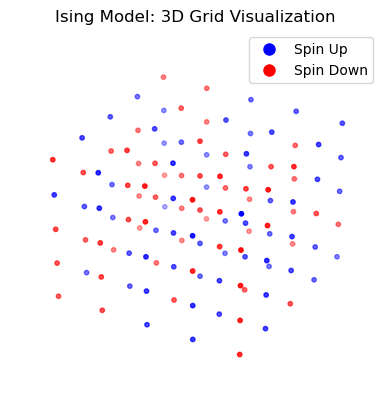

In [20]:
# Random seed
rnd.seed(123)

# Initialization
state = 2 * np.random.randint(2, size=(grid, grid, grid)) - 1

# Plot
fig_3d = plt.figure(figsize=(4, 6))
# Create a meshgrid for x, y, and z coordinates
x, y, z = np.meshgrid(np.arange(grid), np.arange(grid), np.arange(grid))
# Flatten the state matrix for plotting
state_flat = state.flatten()
# Define colors (blue for 1, red for -1)
colors = np.where(state_flat == 1, 'blue', 'red')
# Create a 3D scatter plot
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors, marker='o', s=10)
ax_3d.set_title('Ising Model: 3D Grid Visualization')
ax_3d.set_axis_off()

# Adjust layout to prevent overlap
plt.tight_layout()
# Show legend
blue_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Spin Up')
red_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Spin Down')

plt.legend(handles=[blue_handle, red_handle])

# Show the subplots
plt.show()

Now I will provide some visualization to study and appreicate how energy and magnetization change according to temperature


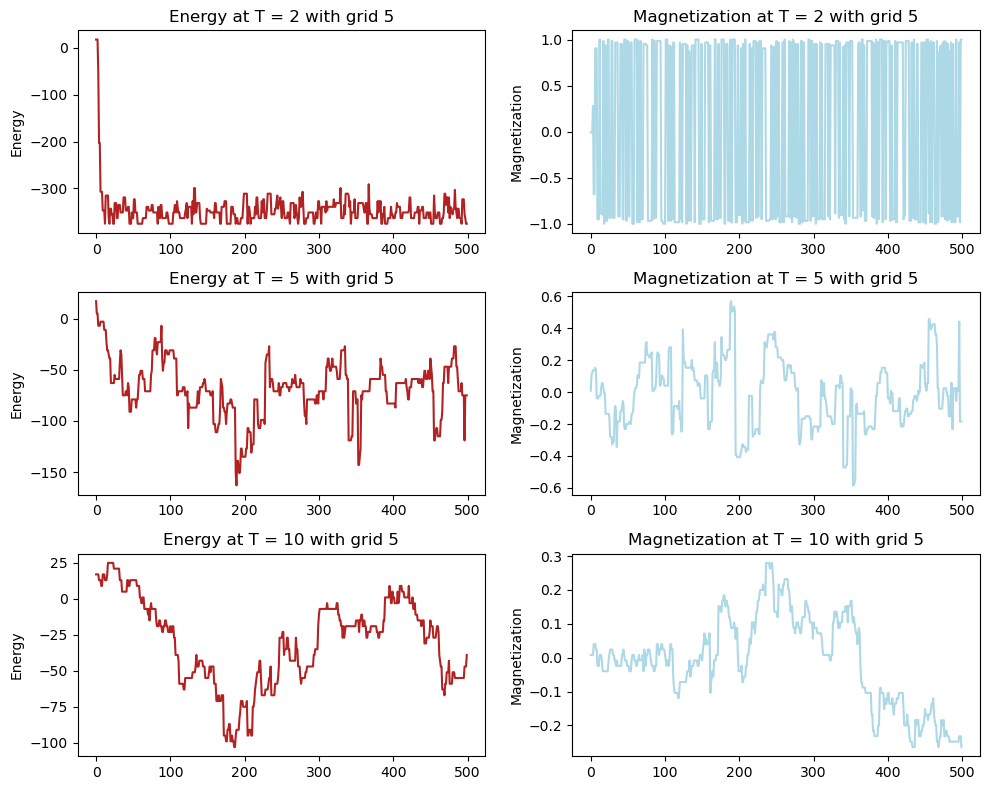

In [21]:
# This simulation is for viewing how energy and magnetization change for a fixed temperature

temp_list = [2,5,10]


# Create a new figure for energy and magnetization plots
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 8))

# First temperature
e_hist_1,m_hist_1,state_1 = simulate_WA(state.copy(),temp_list[0],grid)
# Plot e_hist_1
ax1.plot(e_hist_1, color='firebrick')
ax1.set_title(f'Energy at T = {temp_list[0]} with grid {grid}')
ax1.set_ylabel('Energy')
# Plot m_hist_1
ax2.plot(m_hist_1, color='lightblue')
ax2.set_title(f'Magnetization at T = {temp_list[0]} with grid {grid}')
ax2.set_ylabel('Magnetization')
# Second Temperature
e_hist_2,m_hist_2,state_2= simulate_WA(state.copy(),temp_list[1],grid)
# Plot e_hist_2
ax3.plot(e_hist_2, color='firebrick')
ax3.set_title(f'Energy at T = {temp_list[1]} with grid {grid}')
ax3.set_ylabel('Energy')
# Plot m_hist_2
ax4.plot(m_hist_2, color='lightblue')
ax4.set_title(f'Magnetization at T = {temp_list[1]} with grid {grid}')
ax4.set_ylabel('Magnetization')
# Third temperature
e_hist_3,m_hist_3,state_3= simulate_WA(state.copy(),temp_list[2],grid)
# Plot e_hist_3
ax5.plot(e_hist_3, color='firebrick')
ax5.set_title(f'Energy at T = {temp_list[2]} with grid {grid}')
ax5.set_ylabel('Energy')
# Plot m_hist_3
ax6.plot(m_hist_3, color='lightblue')
ax6.set_title(f'Magnetization at T = {temp_list[2]} with grid {grid}')
ax6.set_ylabel('Magnetization')

plt.tight_layout()

plt.show()


In this comparison, the behaviour is close to Metropolis-Hastings algorithm. Remarkably, the results are consistent even with significantly fewer steps, underscoring the algorithm's robustness. The primary distinction lies in the magnetization at T=1, where the magnetization changes with each iteration due to the complete spin flip at this temperature. Despite this difference, the overall behavior aligns closely with expectations from MH, highlighting the efficacy of the method.

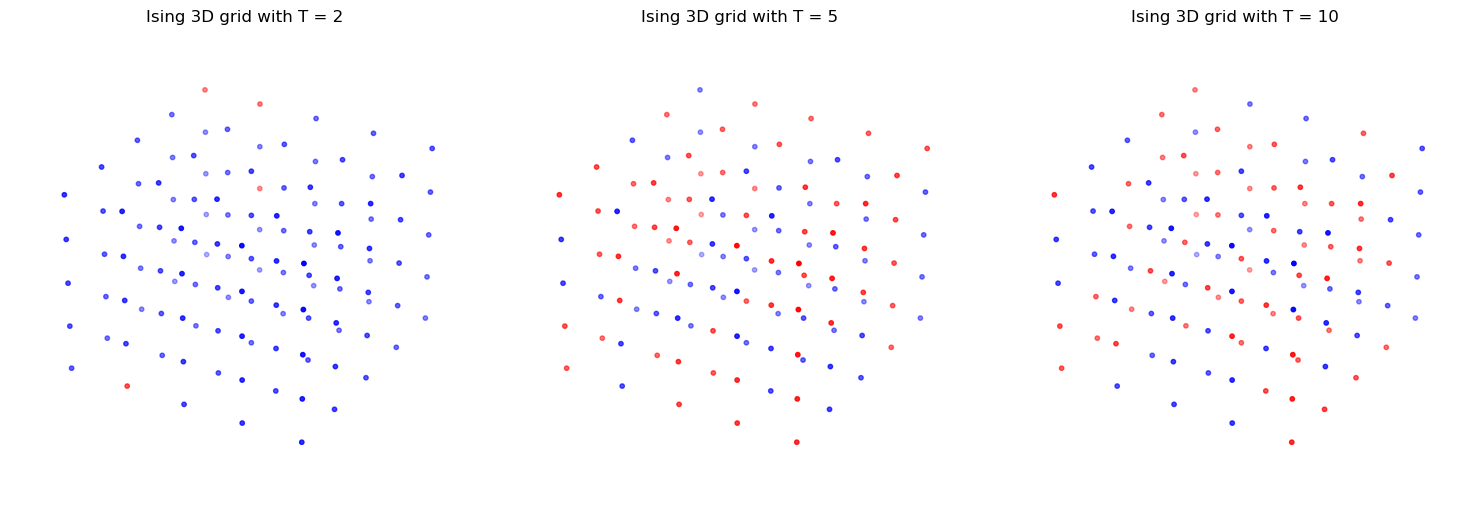

In [55]:
# Let us plot the 3 grids in order to have a visual representation

# Create a meshgrid for x, y, and z coordinates
x, y, z = np.meshgrid(np.arange(grid), np.arange(grid), np.arange(grid))

# Flatten the state matrix for plotting
state_flat_1 = state_1.flatten()
state_flat_2 = state_2.flatten()
state_flat_3 = state_3.flatten() 

# Define colors (blue for 1, red for -1)
colors1 = np.where(state_flat_1 == 1, 'blue', 'red')
colors2 = np.where(state_flat_2 == 1, 'blue', 'red')
colors3 = np.where(state_flat_3 == 1, 'blue', 'red')  

# Create a 3D scatter plot for the first state
fig_3d_1 = plt.figure(figsize=(15, 5))  
ax_3d_1 = fig_3d_1.add_subplot(131, projection='3d')  
ax_3d_1.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors1, marker='o', s=10)
ax_3d_1.set_title(f'Ising 3D grid with T = {temp_list[0]}')
ax_3d_1.set_axis_off()

# Create a 3D scatter plot for the second state
ax_3d_2 = fig_3d_1.add_subplot(132, projection='3d') 
ax_3d_2.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors2, marker='o', s=10)
ax_3d_2.set_title(f'Ising 3D grid with T = {temp_list[1]}')
ax_3d_2.set_axis_off()

# Create a 3D scatter plot for the third state
ax_3d_3 = fig_3d_1.add_subplot(133, projection='3d')  
ax_3d_3.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors3, marker='o', s=10)  
ax_3d_3.set_title(f'Ising 3D grid with T = {temp_list[2]}')
ax_3d_3.set_axis_off()

plt.tight_layout()
plt.show()

Given the definition of the Wolff Algorithm and its assumption of a constant acceptance rate, it's expected that the results obtained will differ from those of the Metropolis-Hastings method. Specifically, at lower temperatures, magnetization will oscillate between 1 and -1, resulting in an average magnetization of zero.

In light of this, it may be more meaningful to focus on plotting energy and magnetization for various grid sizes rather than directly analyzing the plot of temperature and magnetization depicted in the Metropolis-Hastings method. This approach could provide deeper insights into the behavior of the system under different conditions.

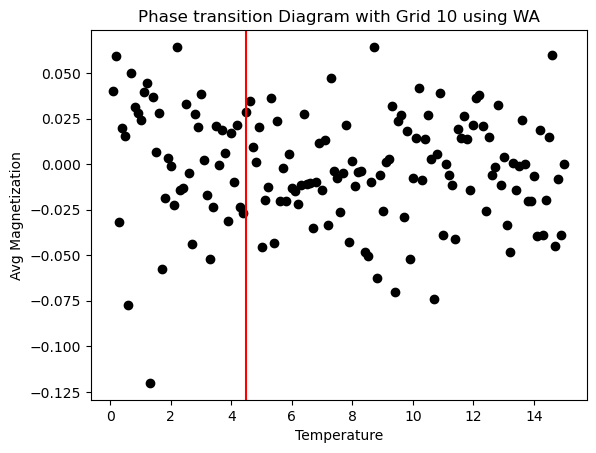

In [42]:
# Example of phase transition diagram that is close to zero for all temperatures
m = []
temp_for_plot = [0.1 +(0.1*step) for step in range(70)]
state = 2 * np.random.randint(2, size=(grid, grid, grid)) - 1
for temps in temp_for_plot:
    m.append(MagvsTemp_WA(state.copy(), temps, grid))

plt.scatter(temp_for_plot,m,color = "black")
plt.title(f'Phase transition Diagram with Grid {grid} using WA')
plt.ylabel("Avg Magnetization")
plt.xlabel("Temperature")
plt.axvline(x = 4.5, color = "red")
plt.show()

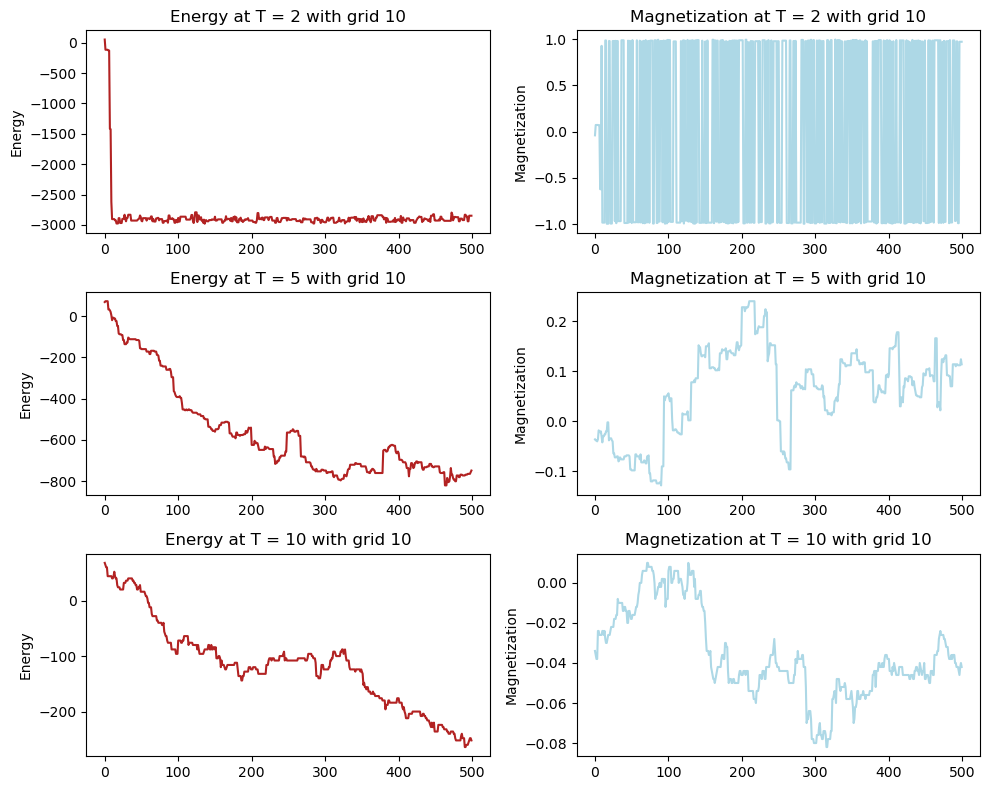

In [22]:
grid = 10
temp_list = [2,5,10]
state = 2 * np.random.randint(2, size=(grid, grid, grid)) - 1


# Create a new figure for energy and magnetization plots
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 8))

# First temperature
e_hist_1,m_hist_1,state_1 = simulate_WA(state.copy(),temp_list[0],grid)
# Plot e_hist_1
ax1.plot(e_hist_1, color='firebrick')
ax1.set_title(f'Energy at T = {temp_list[0]} with grid {grid}')
ax1.set_ylabel('Energy')
# Plot m_hist_1
ax2.plot(m_hist_1, color='lightblue')
ax2.set_title(f'Magnetization at T = {temp_list[0]} with grid {grid}')
ax2.set_ylabel('Magnetization')
# Second Temperature
e_hist_2,m_hist_2,state_2= simulate_WA(state.copy(),temp_list[1],grid)
# Plot e_hist_2
ax3.plot(e_hist_2, color='firebrick')
ax3.set_title(f'Energy at T = {temp_list[1]} with grid {grid}')
ax3.set_ylabel('Energy')
# Plot m_hist_2
ax4.plot(m_hist_2, color='lightblue')
ax4.set_title(f'Magnetization at T = {temp_list[1]} with grid {grid}')
ax4.set_ylabel('Magnetization')
# Third temperature
e_hist_3,m_hist_3,state_3= simulate_WA(state.copy(),temp_list[2],grid)
# Plot e_hist_3
ax5.plot(e_hist_3, color='firebrick')
ax5.set_title(f'Energy at T = {temp_list[2]} with grid {grid}')
ax5.set_ylabel('Energy')
# Plot m_hist_3
ax6.plot(m_hist_3, color='lightblue')
ax6.set_title(f'Magnetization at T = {temp_list[2]} with grid {grid}')
ax6.set_ylabel('Magnetization')

plt.tight_layout()

plt.show()

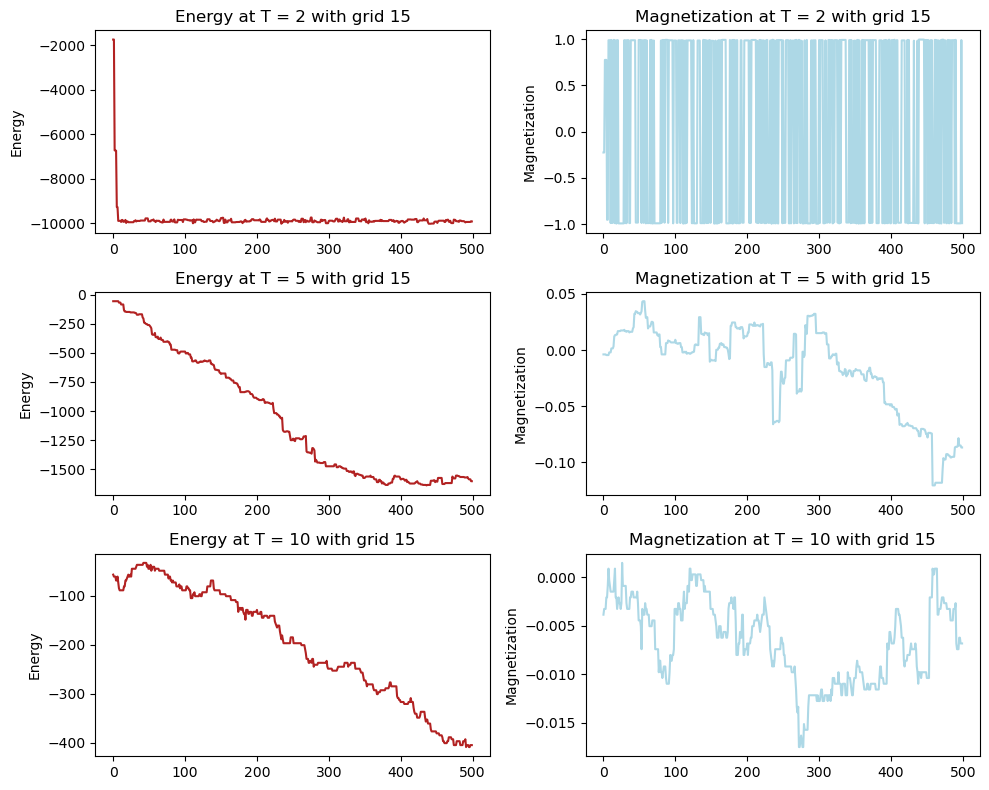

In [23]:
grid = 15
temp_list = [2,5,10]
state = 2 * np.random.randint(2, size=(grid, grid, grid)) - 1


# Create a new figure for energy and magnetization plots
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 8))

# First temperature
e_hist_1,m_hist_1,state_1 = simulate_WA(state.copy(),temp_list[0],grid)
# Plot e_hist_1
ax1.plot(e_hist_1, color='firebrick')
ax1.set_title(f'Energy at T = {temp_list[0]} with grid {grid}')
ax1.set_ylabel('Energy')
# Plot m_hist_1
ax2.plot(m_hist_1, color='lightblue')
ax2.set_title(f'Magnetization at T = {temp_list[0]} with grid {grid}')
ax2.set_ylabel('Magnetization')
# Second Temperature
e_hist_2,m_hist_2,state_2= simulate_WA(state.copy(),temp_list[1],grid)
# Plot e_hist_2
ax3.plot(e_hist_2, color='firebrick')
ax3.set_title(f'Energy at T = {temp_list[1]} with grid {grid}')
ax3.set_ylabel('Energy')
# Plot m_hist_2
ax4.plot(m_hist_2, color='lightblue')
ax4.set_title(f'Magnetization at T = {temp_list[1]} with grid {grid}')
ax4.set_ylabel('Magnetization')
# Third temperature
e_hist_3,m_hist_3,state_3= simulate_WA(state.copy(),temp_list[2],grid)
# Plot e_hist_3
ax5.plot(e_hist_3, color='firebrick')
ax5.set_title(f'Energy at T = {temp_list[2]} with grid {grid}')
ax5.set_ylabel('Energy')
# Plot m_hist_3
ax6.plot(m_hist_3, color='lightblue')
ax6.set_title(f'Magnetization at T = {temp_list[2]} with grid {grid}')
ax6.set_ylabel('Magnetization')

plt.tight_layout()

plt.show()

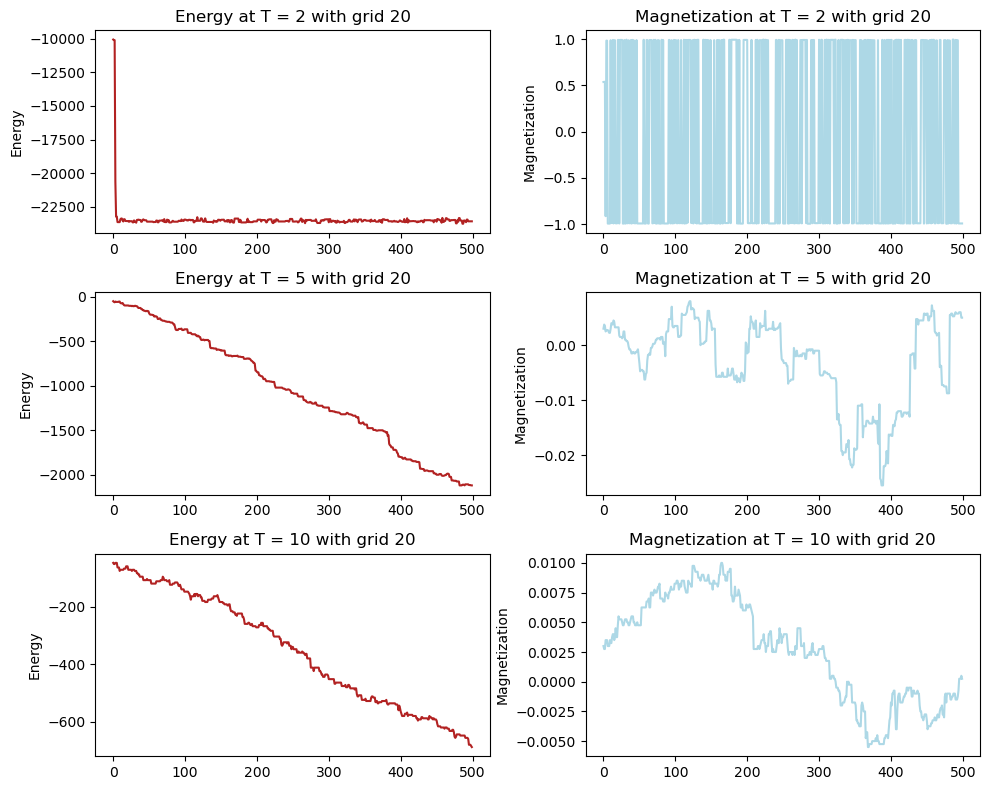

In [24]:
grid = 20
temp_list = [2,5,10]
state = 2 * np.random.randint(2, size=(grid, grid, grid)) - 1


# Create a new figure for energy and magnetization plots
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(10, 8))

# First temperature
e_hist_1,m_hist_1,state_1 = simulate_WA(state.copy(),temp_list[0],grid)
# Plot e_hist_1
ax1.plot(e_hist_1, color='firebrick')
ax1.set_title(f'Energy at T = {temp_list[0]} with grid {grid}')
ax1.set_ylabel('Energy')
# Plot m_hist_1
ax2.plot(m_hist_1, color='lightblue')
ax2.set_title(f'Magnetization at T = {temp_list[0]} with grid {grid}')
ax2.set_ylabel('Magnetization')
# Second Temperature
e_hist_2,m_hist_2,state_2= simulate_WA(state.copy(),temp_list[1],grid)
# Plot e_hist_2
ax3.plot(e_hist_2, color='firebrick')
ax3.set_title(f'Energy at T = {temp_list[1]} with grid {grid}')
ax3.set_ylabel('Energy')
# Plot m_hist_2
ax4.plot(m_hist_2, color='lightblue')
ax4.set_title(f'Magnetization at T = {temp_list[1]} with grid {grid}')
ax4.set_ylabel('Magnetization')
# Third temperature
e_hist_3,m_hist_3,state_3= simulate_WA(state.copy(),temp_list[2],grid)
# Plot e_hist_3
ax5.plot(e_hist_3, color='firebrick')
ax5.set_title(f'Energy at T = {temp_list[2]} with grid {grid}')
ax5.set_ylabel('Energy')
# Plot m_hist_3
ax6.plot(m_hist_3, color='lightblue')
ax6.set_title(f'Magnetization at T = {temp_list[2]} with grid {grid}')
ax6.set_ylabel('Magnetization')

plt.tight_layout()

plt.show()

The discussion for these plots parallels that of the Metropolis-Hastings algorithm. We've achieved the desired results across different grid sizes, but to enhance computational significance, increasing the number of steps is advisable. Nonetheless, the trends remain consistent:

1. **T = 1**: Ising Grid is completely magnetized for all grid sizes.
2. **T = 5**: we expect a more random behaviour but as we see by the energy plot the Wolff algorithm converge faster to minimum energy telling us is a good speed up algorithm. However, as we increase the grid we can see that magnetization for this temperature is in a neighbourhood of zero telling us that probably it requires more steps to refine.
3. **T = 10**: the behavior is consistent across all grid sizes, as the Ising Grid is completely depolarized at such high temperatures. However, the only difference is that energy reaches minimum for all grid sizes also here given the construction of Wolff algorithm.

